In [1]:
!pip install seaborn sklearn

     |████████████████████████████████| 292 kB 1.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 22.2 MB 987 kB/s             
     |████████████████████████████████| 306 kB 1.3 MB/s            
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=a206ebf42a398b6d2afe07225605970750938f25b3d8c8f72e03f7e3331bd0f6
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import uniform, seed
from scipy.interpolate import griddata
from matplotlib.font_manager import FontProperties

In [3]:
sns_colors = sns.color_palette('colorblind')

In [4]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

In [5]:
xtrain = pd.read_csv('dataset/hotel_bookings.csv')
xtrain.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [6]:
xvalid = xtrain.loc[xtrain['reservation_status_date'] >= '2017-08-01']
xtrain = xtrain.loc[xtrain['reservation_status_date'] < '2017-08-01']

xvalid.info()
print("-"*40)
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3810 entries, 13153 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           3810 non-null   object 
 1   is_canceled                     3810 non-null   int64  
 2   lead_time                       3810 non-null   int64  
 3   arrival_date_year               3810 non-null   int64  
 4   arrival_date_month              3810 non-null   object 
 5   arrival_date_week_number        3810 non-null   int64  
 6   arrival_date_day_of_month       3810 non-null   int64  
 7   stays_in_weekend_nights         3810 non-null   int64  
 8   stays_in_week_nights            3810 non-null   int64  
 9   adults                          3810 non-null   int64  
 10  children                        3810 non-null   float64
 11  babies                          3810 non-null   int64  
 12  meal                        

In [7]:
ytrain, yvalid = xtrain['is_canceled'], xvalid['is_canceled']
xtrain.drop('is_canceled', axis=1, inplace=True)
xvalid.drop('is_canceled', axis=1, inplace=True)

In [8]:
xtrain.drop(['arrival_date_year', 'assigned_room_type', 'booking_changes', 'reservation_status', 'country', 'days_in_waiting_list'], axis=1, inplace=True)

In [9]:
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies","is_repeated_guest", "previous_cancellations", "previous_bookings_not_canceled", "agent", "company", "required_car_parking_spaces", "total_of_special_requests", "adr"]
cat_features = ["hotel", "arrival_date_month", "meal", "market_segment", "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [10]:
feature_columns = []
for feature_name in cat_features:
    vocabulary = xtrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in num_features:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [11]:
NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))

        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # for training, cycle thru dataset as many times as need (n_epochs=None)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [12]:
train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xvalid, yvalid, shuffle=False, n_epochs=1)

In [13]:
params = {
    'n_trees': 125,
    'max_depth': 5,
    'n_batches_per_layer': 1,
    'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnjuvh99c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs in

In [14]:
est.train(train_input_fn, max_steps=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpnjuvh99c/model.ckpt.
Type is unsuppo

In [15]:
# evaluation
result = est.evaluate(eval_input_fn)
pd.Series(result).to_frame()

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-07-12T13:35:05Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnjuvh99c/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.79849s
INFO:tensorflow:Finished evaluation at 2022-07-12-13:35:06
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7661417, accuracy_baseline = 0.9160105, auc = 0.65879214, auc_precision_recall = 0.20410985, average_loss = 0.48828837, global_step = 100, label/mean = 0.0839895, loss = 0.48828837, precision = 0.13906448, prediction/mean = 0.32983992, recall = 0.34375
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warn

,0
accuracy,0.766142
accuracy_baseline,0.916010
auc,0.658792
auc_precision_recall,0.204110
average_loss,0.488288
label/mean,0.083990
loss,0.488288
precision,0.139064
prediction/mean,0.329840
recall,0.343750


In [16]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnjuvh99c/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [17]:
!pip install sklearn

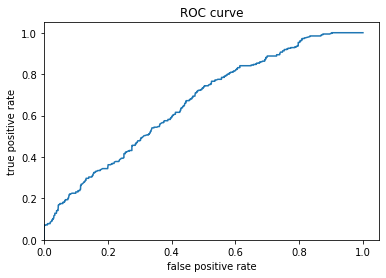

In [18]:
import sklearn
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(yvalid, probs)
plt.plot(fpr, tpr)

plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [19]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

# create DFC pandas dataframe
labels = yvalid.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnjuvh99c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

,count,mean,std,min,25%,50%,75%,max
lead_time,3810.0,-0.004485,0.061705,-0.191197,-3.604294e-02,6.679624e-03,3.299260e-02,0.147218
arrival_date_week_number,3810.0,0.015882,0.022529,-0.050535,4.454481e-03,1.019943e-02,1.391525e-02,0.109846
market_segment,3810.0,-0.012336,0.040498,-0.183300,-4.575146e-02,-1.504659e-02,1.965516e-02,0.071506
arrival_date_day_of_month,3810.0,0.005256,0.014450,-0.030511,0.000000e+00,0.000000e+00,0.000000e+00,0.080807
adr,3810.0,0.014715,0.019101,-0.041049,4.661684e-04,9.332971e-03,2.420047e-02,0.122456
arrival_date_month,3810.0,0.017457,0.013262,-0.031964,6.945259e-03,1.614741e-02,3.111664e-02,0.047668
previous_cancellations,3810.0,-0.021915,0.019762,-0.071427,-3.084422e-02,-2.623832e-02,-7.903311e-03,0.282700
deposit_type,3810.0,-0.022578,0.014007,-0.079781,-2.388465e-02,-2.288193e-02,-2.108757e-02,0.152903
agent,3810.0,0.002485,0.023187,-0.051245,-9.830812e-03,-1.615743e-03,4.518328e-03,0.101586
customer_type,3810.0,-0.001931,0.033812,-0.140865,-8.802847e-03,3.483284e-03,1.571920e-02,0.134454


In [20]:
def _get_color(value):
    """
    To make positive DFCs plot green, negative DFCs plot red.
    :param value:
    :return:
    """
    green, red = sns.color_palette()[2:4]
    return green if value >= 0 else red

In [21]:
from matplotlib.font_manager import FontProperties

def _add_feature_value(feature_values, ax):
    """
    display feature's values on left of plot
    :param feature_values:
    :param ax:
    :return:
    """
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
        font = FontProperties()
        font.set_weight('bold')
        t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue', fontproperties=font, size=12)

In [22]:
def plot_example(example):
    TOP_N = 8 # view top features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # sort by magnitude
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh', color=[colors],
                                 legend=None,
                                 alpha=0.75,
                                 figsize=(10, 6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)

    # add feature values
    _add_feature_value(xvalid.iloc[ID][sorted_ix], ax)
    return ax

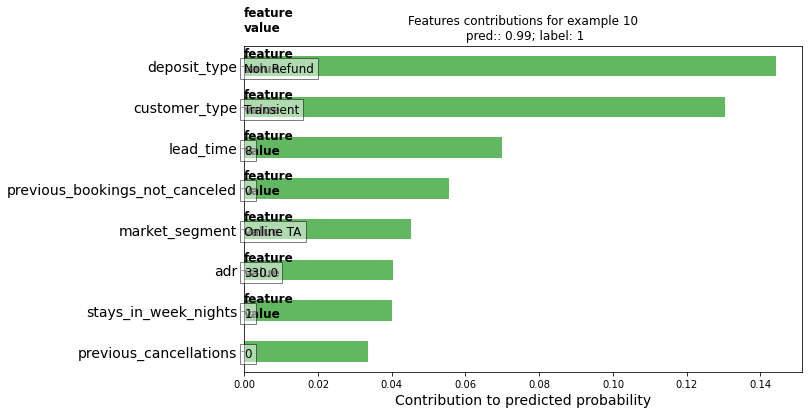

In [23]:
ID = 10
example = df_dfc.iloc[ID]
TOP_N = 8
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Features contributions for example {}\n pred:: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()

In [29]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """
    Column by colum, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance" in the above article.
    :param est:
    :param X_eval:
    :param y_eval:
    :param metric:
    :param features:
    :return:
    """
    baseline = metric(est,X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline-m)
    return np.array(imp)

In [27]:
def accuracy_metric(est, X, y):
    """
    tensorflow estimator accuracy.
    :param est:
    :param X:
    :param y:
    :return:
    """
    eval_input_fn = make_input_fn(X, y, shuffle=False, n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-07-12T14:42:07Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnjuvh99c/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.83157s
INFO:tensorflow:Finished evaluation at 2022-07-12-14:42:08
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.7661417, accuracy_baseline = 0.9160105, auc = 0.65879214, auc_precision_recall = 0.20410985, average_loss = 0.48828837, global_step = 100, label/mean = 0.0839895, loss = 0.48828837, precision = 0.13906448, prediction/mean = 0.32983992, recall = 0.34375
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmpnjuvh99c/model.ckpt-100
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-07-12T14:42:08Z
INFO:tensorflow:Graph 

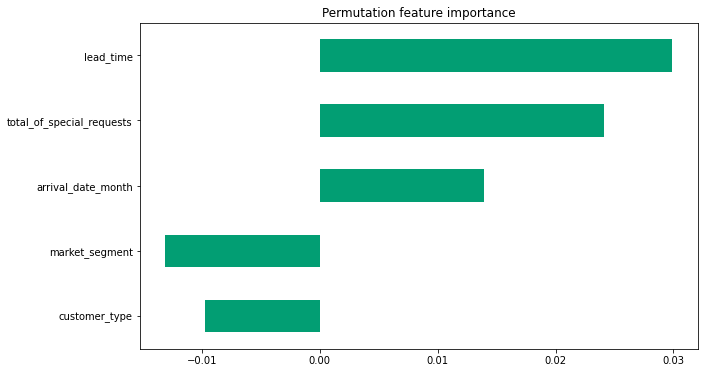

In [30]:
features = cat_features + num_features
importances = permutation_importances(est, xvalid, yvalid, accuracy_metric, features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')

plt.show()

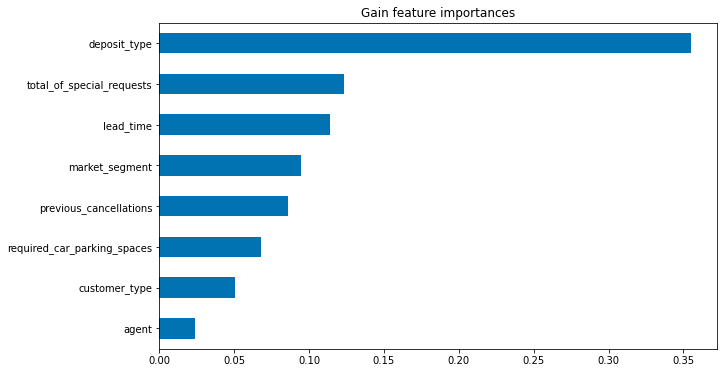

In [31]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# visualize importances
N = 8
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh', color=sns_colors[0], title='Gain feature importances', figsize=(10, 6)))
ax.grid(False, axis='y')

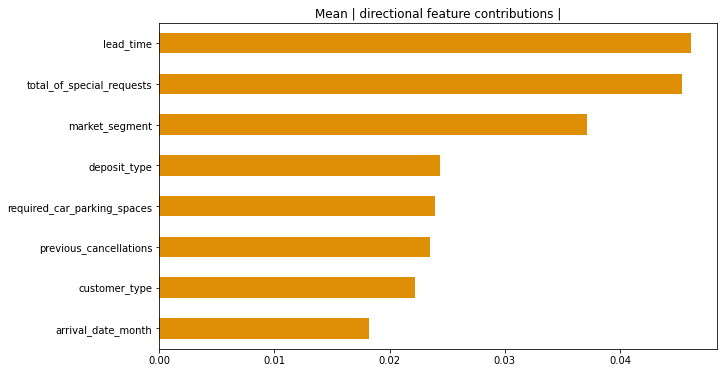

In [33]:
dfc_mean = df_dfc.abs().mean()
N = 8
sorted_ix = dfc_mean.abs().sort_values()[-N:].index

ax = dfc_mean[sorted_ix].plot(kind='barh',
                              color=sns_colors[1],
                              title='Mean | directional feature contributions |',
                              figsize=(10, 6))
ax.grid(False, axis='y')